In [11]:
import math
import matplotlib.pyplot as plt
#
from steelpy import CodeCheck
from steelpy import Formulas
from steelpy import Materials
from steelpy import Sections
from steelpy import Units
#
units = Units()
code = CodeCheck()
formulas = Formulas()

In [12]:
#
# Pipe Section
#
Dp = 219.10 * units.mm
#tp = 8.626 * units.mm
tp = 14.3 * units.mm
# -----------------------------------
# Define sections
section = Sections()
section["TUB"] = ['Tubular', Dp, tp]
#
# -----------------------------------
# define material
SMYS = 170.0 * units.MPa
SMTS = 485.0 * units.MPa
material = Materials()
material["X65"] = ['elastic', SMYS, SMTS]
#
# Pressure
Pe = 67.50 * units.bar
Pi = 93 * units.bar
#
# Temperature
PipeTemp = 0*(50 + 273.15) * units.K
#

In [13]:
#
# Clamp Section
# 
L1 = 600 * units.mm
L2 = 355 * units.mm
L3 = 245 * units.mm

In [14]:
#
# Bolt Section 
# M30x3.5
n_bolt = 1 # number of bolts
d_bolt = 30 * units.mm  # Size of the bolt
As_bolt = 561 * units.mm**2 # Bolt stress area 
thetaf_bolt = 30 * units.degrees  # Flank angle of thread
Pp_bolt = 3.5 * units.mm # Thread pitch
kw_bolt = 46 * units.mm  # key width
h_bolt  = 31 * units.mm  # Bolt hole
#
# Friction coefficient, Molycote P-40
muf_bolt = 0.16

In [15]:
Rrad_bolt = (4*As_bolt/math.pi)**0.50/2
print(f"Effective Pitch Radious {Rrad_bolt.convert('millimetre').value : 1.2f} mm")
#
Rs_bolt = (kw_bolt + h_bolt) / 4
print(f"R bolt = {Rs_bolt.convert('millimetre').value : 1.2f} mm")

Effective Pitch Radious  13.36 mm
R bolt =  19.25 mm


In [16]:
#
# Torque requirements
#
Mtorque = [item * units.N * units.m for item in range(1000)]
#
boltf = (Pp_bolt/math.tau + Rrad_bolt * muf_bolt/math.cos(thetaf_bolt.value)
         + Rs_bolt * muf_bolt)
#
#Tr = boltf * 68 * units.kN
#print(Tr.convert('newton*metre').value)
#print((Tr/boltf ).convert('kilonewton').value)
#
Fset = [item/boltf for item in Mtorque]
#
Fs = [L2*item/L1 for item in Fset]
#

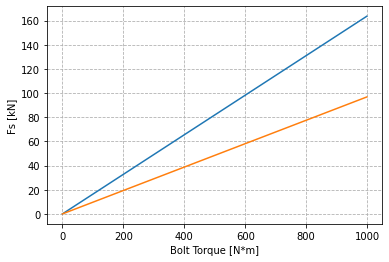

In [17]:
#
#
plt.plot([item.convert('newton*metre').value for item in Mtorque],
         [item.convert('kilonewton').value for item in Fset])
#
plt.plot([item.convert('newton*metre').value for item in Mtorque],
         [item.convert('kilonewton').value for item in Fs])
plt.xlabel('Bolt Torque [N*m]')
plt.ylabel('Fs [kN]')
plt.grid(True, linestyle='--')
plt.show()

In [18]:
#
# Roark's Circular Ring Case 12
# 
#Theta_r = 60 * units.degrees
#
Torque_applied = 418 * units.newton  * units.metre
Mt_index = [x for x, item in enumerate(Mtorque)
            if item.value == Torque_applied.value ]
#print(Mt_index)
Fs_i = Fs[Mt_index[0]]
print(f"Fs = {Fs_i.convert('kilonewton').value:1.2f} kN @ Torque = {Torque_applied.convert('newton*metre').value: 1.2f} N-m")
#
R = Dp * 0.50
I = (math.pi / 64.0 * Dp**4 - (Dp - 2*tp)**4)
A = (math.pi / 4. * (Dp**2 -(Dp - 2*tp)**2))
Ze = (math.pi/64.0 
      * (Dp**4 - (Dp - 2 * tp)**4) / (Dp / 2.0))
Zp = ((Dp**3 - (Dp - 2 * tp)**3) / 6.0 )
#
alpha = I/(A*R**2)
k2 = 1 - alpha.value
#
#a = R*math.sin(Theta_r.value)
a = 150 * units.mm * 0.50
a = 60 * units.mm * 0.50
print(f"Bottom Pad = {2*a.convert('millimetre').value:1.3f} mm")
Theta = math.degrees(math.asin(a.value/R.value)) * units.degrees
print(f"Theta = {Theta.convert('degree').value:1.3f} deg")
w = 0.50 * Fs_i / (2*a)
s = math.sin(Theta.value)
c = math.cos(Theta.value)
# 
Mc = (-1*w*R**2/math.pi * (math.pi - s + Theta.value*c - k2 * (math.pi - Theta.value - s)))
print(f"Mc = {Mc.convert('kilonewton*metre').value : 1.2f} kN-m")

Fs = 40.50 kN @ Torque =  418.00 N-m
Bottom Pad = 60.000 mm
Theta = 15.893 deg
Mc =  35.71 kN-m


In [19]:
#
# Pipe  stress
#
print(f"Section modulus e = {Ze.convert('millimetre^3').value : 1.3e} mm^3")
print(f"Section modulus p = {Zp.convert('millimetre^3').value : 1.3e} mm^3")
#
sigma_e = Mc/Ze
sigma_p = Mc/Zp
print(f"Bending stress e = {sigma_e.convert('megapascal').value : 1.2f} MPa")
print(f"Bending stress p = {sigma_p.convert('megapascal').value : 1.2f} MPa")

Section modulus e =  4.425e+05 mm^3
Section modulus p =  6.008e+05 mm^3
Bending stress e =  80.72 MPa
Bending stress p =  59.45 MPa


In [37]:
ring2 = formulas.ring(72)
ring2.material = material["X65"]
ring2.geometry = section["TUB"]
#
W = Fs_i * 0.50
phase = 0 * units.deg
ring2.load[12] = {'case': 12, 'W': W, 'theta': Theta, 'phase': phase}
#
force = ring2.radial_force
#forces[12].printout()
#forces[12].plot2d()
#
Mmax = force.Mmax * units.N * units.m
print(f'Mmax = {Mmax.convert("kilonewton*metre").value : 1.3e} kN-m')
#
Nmax = force.Nmax * units.N
print(f'Nmax = {Nmax.convert("kilonewton").value : 1.3e} kN')
#
Vmax = force.Vmax * units.N
print(f'Vmax = {Vmax.convert("kilonewton").value : 1.3e} kN')

========= 0 ============
k Factors
R/d = [7.161] thick ring
k1 = 1.005 k2 = 0.998


Roark case 12 Uniform Radial Unit Load

R:  1.024e-01 m
Applied load W:  2.025e+04
Applied load w:  3.611e+05
Phase:  0.000 deg
Theta:  15.893 deg

Applied load w :  361106.21457669896
Mmax = -6.610e-01 kN-m
Nmax = -3.689e+01 kN
Vmax = -1.013e+01 kN


In [38]:
#
# =====================
# 
# =====================
#
pipegl = code.pipe
pipegl.design_code("PD8010 Part 2")
pipegl.design_data(design_condition = "operating", 
                   design_method = 'stress')
#
# ----------------------
# Pipe details
#
pipegl.pipe_data(pipe_type = "Seabed", 
                 pipe_name="Exp-Flowline",
                 pipe_restraint=False,
                 pipe_history = False)
#
#
pipegl.pipe_section(tcorr = 3*units.mm, 
                    tol = 0.08, fo = 0.025)
#
#
pipegl.section = section["TUB"]
#
# ----------------------
# 4.- Material Data (N/mm2)
#
pipegl.material = material["X65"]
#
#
#pipegl.material_derate(material_type="CMn",
#                      derate_code="DNV",
#                      Tmax=60.0)
#
# ----------------------
# 6.- Design Pressure (N/mm2)
#
pipegl.design_pressure(Pi = Pi, Po = Pe)
#
# ----------------------
# 7.- Design Temperature in degrees Celsius (C)
#
pipegl.design_temperature(T1 = 0 * units.K, 
                          T2 = PipeTemp)
#
# ----------------------
# 8.- Forces from Analysis
#
Fx = 0 * units.N
Fy = 0 * units.N
Bm = Mc
pipegl.enviromental_load(Px = Fx,  # [-ve Compression] (N)
                         Vip = Fy, # (N)
                         BMip = Bm)  # (N-mm)

#pipegl.functional_load(Fa = Fx,  # [-ve Compression] (N)
#                       Fs = Fy, # (N)
#                       Mb = Bm, # (N*m)
#                       T = 0 * units.N * units.m)  
#
#
pipegl.set_substance_category("E")
#
# ----------------------
# Perform Calcs & Print Resuls
#
pipegl.get_results()
#Pipe2.print_results()
#
#
#
#
#print('end')


Section Properties
Do = 219.100 mm
t nom = 14.300 mm
t corr = 3.000 mm
t min = 10.156 mm

Material Properties
Fy =  1.700e+02 MPa
Fu =  4.850e+02 MPa
E =   2.050e+05 MPa
Coefficient of Thermal Expansion = -3.649e-03 C^-1

Design Factors
Test Data  = operating
Pipe Type  = Seabed
fd         = 0.960
fd hs      = 0.720

Expansion Flexibility 
Based on : None
Member Description: pipe
Member Type: straight
h  = 1.000
k  = 1.000
lo = 1.000
li = 1.000
C1 = 1.000

Enviromental Stress Calculation
Equivalent Stress = 8.072e+01 MPa
 
Longitudinal Stress Calculation
Pressure    =  2.550e+01 bar
Temperature =  0.000e+00 C
Fx          =  0.000e+00 kN
Mb          =  0.000e+00 kN-m
-----------------------------
Sigma_b     =  0.000e+00 MPa
Sigma_x     =  0.000e+00 MPa
k  = 1.000e+00
-----------------------------
Sigma_L     =  9.175e+00 MPa

Shear stress
Tau  = 0.000
 
Functional Stress Calculation
Von Mises Equivalent Stress = 15.891

Total equivalent stress : 96.606

External Overpressure P : 2.550